In [1]:
%run ../modules/qpca

<b>General implementation of a Quantum PCA for any size covariance matrices.</b>

In [2]:
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram
from scipy.stats import ortho_group

Generation of the covariance matrix and normalization

In [3]:
#number of features
N = 4

data = scipy.random.rand(10,N)*20
means = np.mean(data,axis=0)
u=np.ones(len(data))[None] 
u=u.reshape((len(data),1)) 
means=means.reshape((len(data[0]),1))
centered = data-np.dot(u,means.T)



covmat = np.dot(centered.transpose(),centered)
covmat=covmat/np.trace(covmat)

for r in covmat:
    #print("&".join([str(c.round(4)) for c in r])+"\\")
    pass
print(covmat)
eigval, eigvec = np.linalg.eig(covmat)
#print("&".join([str(c.round(4)) for c in eigval])+"\\")
print("Eigenvalues: ")
print(eigval)
print("Eigenvectors: ")
print(eigvec)
for r in eigvec:
    #print("&".join([str(c.round(4)) for c in r])+"\\")
    pass

[[ 0.30848749  0.1474397  -0.11145724 -0.06306453]
 [ 0.1474397   0.25339695  0.03675925 -0.12829206]
 [-0.11145724  0.03675925  0.30526153  0.01095866]
 [-0.06306453 -0.12829206  0.01095866  0.13285403]]
Eigenvalues: 
[0.50025217 0.03631935 0.1235661  0.33986238]
Eigenvectors: 
[[-0.70806067 -0.27798963  0.63903877 -0.11402326]
 [-0.54157895  0.63271712 -0.23545567  0.50092106]
 [ 0.32062881 -0.22961216  0.40275667  0.82599182]
 [ 0.32021789  0.68532406  0.61153671 -0.23197909]]


In [4]:
for i in range(N):
    print(f"Eigvector associated to {np.round(eigval[i].real,5)}: [{','.join([str(j.real) for j in np.round(eigvec.T[i],4)])} ].")



Eigvector associated to 0.50025: [-0.7081,-0.5416,0.3206,0.3202 ].
Eigvector associated to 0.03632: [-0.278,0.6327,-0.2296,0.6853 ].
Eigvector associated to 0.12357: [0.639,-0.2355,0.4028,0.6115 ].
Eigvector associated to 0.33986: [-0.114,0.5009,0.826,-0.232 ].


In [49]:
bits = 9
shots_per_vec1 = 10
shots_per_vec2 = 1000
threshold_perc = 0.008
roundoff = 3

pool = ortho_group.rvs(dim=N)
res = None
for i in range(N):
    initial = pool[i]
    if res is None:
        res = qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff)
    else:
        res.merge(qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff))
        
eigval_occurences = res.get_eigvals()

print(eigval_occurences)

#THRESHOLDING

relevant_eigvals = [i[0] for i in eigval_occurences[-N:]]

print(relevant_eigvals)

eigvec_weights = [i/sum(relevant_eigvals) for i in relevant_eigvals]


result = None
for eigval,weight in zip(relevant_eigvals,eigvec_weights):
    initial = res.eigvec_from_eigval(eigval)
    print(f"Using estimate for {eigval}: {initial}, with weight: {weight}")
    if len(initial)==0:
        continue
    if result is None:
        result = qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight+1), nbitsroundoff = roundoff)
    else:
        result.merge(qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight+1), nbitsroundoff = roundoff))

print(result.get_eigvals())

#RETRIEVE EIGVECTORS ESTIMATES

plot_histogram(result.get_eigvals(False))

final_eigenvalues = result.get_eigvals()

eigenvectors = [result.eigvec_from_eigval(i[0]) for i in final_eigenvalues[-N:]]

for i in eigenvectors:
    print(" ",i)

[(0.15625, 1), (0.046875, 2), (0.140625, 2), (0.03125, 24), (0.125, 27), (0.5, 32), (0.34375, 32)]
[0.03125, 0.125, 0.5, 0.34375]
Using estimate for 0.03125: [ 0.          0.63245553  0.4472136  -0.63245553], with weight: 0.03125
Using estimate for 0.125: [ 0.35355339 -0.5         0.35355339  0.70710678], with weight: 0.125
Using estimate for 0.5: [ 0.73854895  0.52223297 -0.30151134 -0.30151134], with weight: 0.5
Using estimate for 0.34375: [ 0.33333333 -0.47140452 -0.74535599  0.33333333], with weight: 0.34375
[(0.0625, 1), (0.078125, 1), (0.09375, 1), (0.53125, 1), (0.46875, 1), (0.171875, 1), (0.515625, 2), (0.484375, 2), (0.03125, 5), (0.140625, 5), (0.109375, 6), (0.125, 364), (0.34375, 1041), (0.5, 1578)]
  [1. 0. 0. 0.]
  [ 0.64375027 -0.21223818  0.39134787  0.62240452]
  [ 0.09245003 -0.50071174 -0.82689823  0.23870496]
  [ 0.72027564  0.51845636 -0.32732684 -0.32444284]


In [29]:
plot_histogram(r.get_eigvals(False))

AttributeError: 'numpy.ndarray' object has no attribute 'get_eigvals'

In [38]:
r.eigvec_from_eigval(0.09375)


Measurements:  [{'1011': 1, '1000': 2, '0111': 2, '0110': 1, '1010': 1, '0011': 1, '0101': 1, '0010': 1}, {'0100': 4, '1000': 3, '1111': 4, '0111': 4, '1001': 3, '0010': 4, '0001': 2, '0101': 1}, {'0100': 2, '0110': 1, '0000': 1, '1110': 1, '0011': 5, '0111': 2, '1101': 2, '1000': 1}, {'0011': 3, '1001': 2, '1000': 3, '0111': 3, '0010': 1, '0000': 1, '1100': 5, '1101': 1, '0001': 1, '0100': 1}, {'1110': 2, '1011': 4, '1111': 3, '0100': 1, '0111': 2, '1101': 3, '1000': 2, '0011': 1, '1001': 1, '0010': 3, '0101': 1}]


array([ 0.        , -0.        ,  0.31622777,  0.31622777,  0.        ,
        0.31622777,  0.31622777, -0.4472136 , -0.4472136 , -0.        ,
       -0.31622777, -0.31622777,  0.        ,  0.        , -0.        ,
        0.        ])

In [39]:
rnew = qpca(covmat,bits,initial= r.eigvec_from_eigval(0.09375), req_shots = 1000, nbitsroundoff = 4)

Measurements:  [{'1011': 1, '1000': 2, '0111': 2, '0110': 1, '1010': 1, '0011': 1, '0101': 1, '0010': 1}, {'0100': 4, '1000': 3, '1111': 4, '0111': 4, '1001': 3, '0010': 4, '0001': 2, '0101': 1}, {'0100': 2, '0110': 1, '0000': 1, '1110': 1, '0011': 5, '0111': 2, '1101': 2, '1000': 1}, {'0011': 3, '1001': 2, '1000': 3, '0111': 3, '0010': 1, '0000': 1, '1100': 5, '1101': 1, '0001': 1, '0100': 1}, {'1110': 2, '1011': 4, '1111': 3, '0100': 1, '0111': 2, '1101': 3, '1000': 2, '0011': 1, '1001': 1, '0010': 3, '0101': 1}]


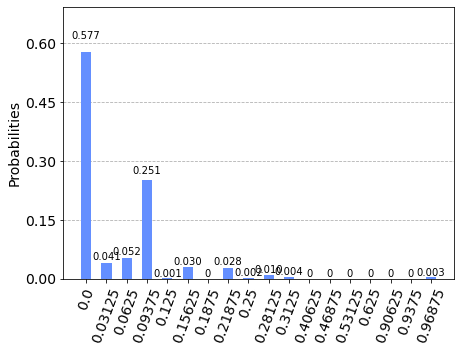

In [40]:
plot_histogram(rnew.get_eigvals(False))

In [41]:
rnew.eigvec_from_eigval(0.09375)

Measurements:  [{'0101': 9, '0011': 27, '1011': 5, '1110': 21, '1111': 6, '1000': 65, '1010': 3, '0111': 47, '0010': 22, '0100': 18, '1001': 3, '0110': 12, '1101': 5, '0001': 7, '1100': 11}, {'0101': 14, '1100': 17, '1011': 4, '1111': 17, '1000': 28, '0000': 9, '0111': 41, '1001': 23, '0001': 6, '0100': 20, '0110': 2, '0010': 61, '1110': 7, '1101': 1, '0011': 1, '1010': 2}, {'0101': 6, '1010': 34, '0011': 51, '1100': 7, '1011': 1, '1000': 30, '0111': 36, '0100': 24, '1001': 10, '0010': 11, '1101': 8, '1110': 14, '0001': 5, '0000': 11, '0110': 13}, {'0101': 13, '0011': 22, '1100': 56, '1000': 20, '0001': 12, '0111': 35, '0010': 19, '0100': 20, '1001': 3, '0110': 21, '1010': 4, '1111': 1, '1101': 5, '1110': 11, '1011': 1, '0000': 6}, {'0101': 11, '0011': 17, '1111': 18, '1100': 4, '1011': 13, '1000': 36, '0001': 2, '0010': 19, '0100': 18, '1001': 10, '0111': 15, '0000': 23, '1101': 8, '1010': 5, '1110': 12, '0110': 18}]


array([ 0.        ,  0.16376789,  0.29032945,  0.32163376, -0.26261287,
       -0.18569534, -0.21442251,  0.42435437, -0.49904123, -0.10721125,
        0.10721125, -0.13840913,  0.20529392,  0.13840913, -0.28365431,
        0.15161961])